## Loading datasets (UCF50, UCF101 and HMDB51)

In [2]:
import kagglehub

# Download latest version
ucf50_path = kagglehub.dataset_download("pypiahmad/realistic-action-recognition-ucf50")

print("Path to dataset files:", ucf50_path)

Path to dataset files: /kaggle/input/realistic-action-recognition-ucf50


In [3]:
import os

ucf50_path = ucf50_path + "/UCF50"
print("Root path:", ucf50_path)
ucf50_classes = list(os.listdir(ucf50_path))
print("Number of classes: ", len(ucf50_classes))
print("Classes: ", ucf50_classes)

Root path: /kaggle/input/realistic-action-recognition-ucf50/UCF50
Number of classes:  50
Classes:  ['HorseRace', 'VolleyballSpiking', 'Biking', 'TaiChi', 'Punch', 'BreastStroke', 'Billiards', 'PoleVault', 'ThrowDiscus', 'BaseballPitch', 'HorseRiding', 'Mixing', 'HighJump', 'Skijet', 'SkateBoarding', 'MilitaryParade', 'Fencing', 'JugglingBalls', 'Swing', 'RockClimbingIndoor', 'SalsaSpin', 'PlayingTabla', 'Rowing', 'BenchPress', 'PushUps', 'Nunchucks', 'PlayingViolin', 'PullUps', 'PlayingPiano', 'HulaHoop', 'RopeClimbing', 'YoYo', 'TrampolineJumping', 'JumpingJack', 'Drumming', 'GolfSwing', 'PlayingGuitar', 'PizzaTossing', 'Lunges', 'TennisSwing', 'WalkingWithDog', 'Kayaking', 'PommelHorse', 'Basketball', 'JumpRope', 'CleanAndJerk', 'Skiing', 'Diving', 'SoccerJuggling', 'JavelinThrow']


In [29]:
import kagglehub

# Download latest version
ucf101_path = kagglehub.dataset_download("pevogam/ucf101")

print("Path to dataset files:", ucf101_path)

Path to dataset files: /kaggle/input/ucf101


In [30]:
import os

ucf101_path = ucf101_path + "/UCF101/UCF-101"
print("Root path:", ucf101_path)
ucf_classes = list(os.listdir(ucf101_path))
print("Number of classes: ", len(ucf_classes))
print("Classes: ", ucf_classes)

Root path: /kaggle/input/ucf101/UCF101/UCF-101
Number of classes:  101
Classes:  ['HorseRace', 'StillRings', 'ApplyLipstick', 'HammerThrow', 'VolleyballSpiking', 'Biking', 'PlayingCello', 'BodyWeightSquats', 'TaiChi', 'Punch', 'BreastStroke', 'Billiards', 'BoxingPunchingBag', 'BasketballDunk', 'PoleVault', 'ThrowDiscus', 'BaseballPitch', 'Knitting', 'SumoWrestling', 'HorseRiding', 'Mixing', 'BrushingTeeth', 'HighJump', 'Skijet', 'SkateBoarding', 'MilitaryParade', 'IceDancing', 'CricketShot', 'Fencing', 'JugglingBalls', 'Swing', 'RockClimbingIndoor', 'PlayingFlute', 'SalsaSpin', 'CricketBowling', 'Typing', 'ApplyEyeMakeup', 'PlayingTabla', 'BalanceBeam', 'FloorGymnastics', 'HeadMassage', 'FrisbeeCatch', 'Rowing', 'Hammering', 'CuttingInKitchen', 'BenchPress', 'PushUps', 'Nunchucks', 'Archery', 'LongJump', 'BlowingCandles', 'WallPushups', 'PlayingViolin', 'PullUps', 'PlayingPiano', 'PlayingDhol', 'FrontCrawl', 'HulaHoop', 'CliffDiving', 'BandMarching', 'ParallelBars', 'RopeClimbing', 'Yo

In [1]:
import kagglehub

# Download latest version
hmdb51_path = kagglehub.dataset_download("easonlll/hmdb51")

print("Path to dataset files:", hmdb51_path)

Path to dataset files: /kaggle/input/hmdb51


In [2]:
import os

hmdb51_path = hmdb51_path + "/HMDB51"
print("Root path:", hmdb51_path)
hmdb51_classes = list(os.listdir(hmdb51_path))
print("Number of classes: ", len(hmdb51_classes))
print("Classes: ", hmdb51_classes)

Root path: /kaggle/input/hmdb51/HMDB51
Number of classes:  51
Classes:  ['kick_ball', 'catch', 'shoot_ball', 'climb_stairs', 'punch', 'stand', 'smoke', 'clap', 'somersault', 'drink', 'pushup', 'push', 'talk', 'fencing', 'golf', 'shake_hands', 'sword', 'kick', 'dive', 'eat', 'kiss', 'climb', 'cartwheel', 'pullup', 'sword_exercise', 'laugh', 'jump', 'pour', 'chew', 'walk', 'shoot_gun', 'dribble', 'smile', 'situp', 'sit', 'fall_floor', 'hug', 'ride_horse', 'swing_baseball', 'flic_flac', 'run', 'pick', 'throw', 'wave', 'draw_sword', 'turn', 'brush_hair', 'hit', 'handstand', 'ride_bike', 'shoot_bow']


## Implementation

In [5]:
import os
import shutil
import random
import numpy as np
from pathlib import Path
from tqdm import tqdm
import math

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler

import torchvision.transforms as transforms
import torchvision.models as models
from einops import rearrange

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# CONFIGURATION
# -----------------------------
CONFIG = {
    'dataset_path': '/kaggle/input/realistic-action-recognition-ucf50/UCF50',
    'save_dir': './checkpoints',
    'teacher_flow_dir': './teacher_flows',

    'num_frames': 16,
    'frames_to_select': 8,
    'img_size': 224,
    'num_classes': 50,

    'batch_size': 8,
    'accumulation_steps': 2,
    'lr': 1e-4,
    'weight_decay': 1e-2,
    'num_workers': 4,

    'epochs_mhn_pretrain': 3,
    'epochs_classifier': 3,
    'epochs_finetune': 3,

    # Set 'precompute_teacher' to False if you have already run it successfully once
    'precompute_teacher': True, 
    'use_teacher_distill': True,

    'lambda_grad': 0.5,
    'beta_flow': 0.5,
    'alpha_sparsity': 0.01,

    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'seed': 42,
    'max_samples': None,
}

# -----------------------------
# UTILS & LOSSES
# -----------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def flow_epe_loss(pred, target):
    return torch.norm(pred - target, dim=1).mean()

def flow_grad_loss(pred, target):
    def gradient(x):
        dx = x[:, :, :, 1:] - x[:, :, :, :-1]
        dy = x[:, :, 1:, :] - x[:, :, :-1, :]
        return dx, dy
    pdx, pdy = gradient(pred)
    tdx, tdy = gradient(target)
    return (pdx - tdx).abs().mean() + (pdy - tdy).abs().mean()

def entropy_sparsity_loss(masks):
    eps = 1e-8
    entropy = -torch.sum(masks * torch.log(masks + eps), dim=-1)
    return entropy.mean()

def gumbel_softmax_sample(logits, tau=1.0):
    u = torch.rand_like(logits)
    g = -torch.log(-torch.log(u + 1e-20) + 1e-20)
    return F.softmax((logits + g) / tau, dim=-1)

# -----------------------------
# MODULES (MHN, AKS, DS-STT)
# -----------------------------
class MotionHallucinationNet(nn.Module):
    def __init__(self, in_ch=6, base_ch=32):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, base_ch, 3, 1, 1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True))
        self.pool = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(nn.Conv2d(base_ch, base_ch*2, 3, 1, 2, 2), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True))
        self.enc3 = nn.Sequential(nn.Conv2d(base_ch*2, base_ch*4, 3, 1, 4, 4), nn.BatchNorm2d(base_ch*4), nn.ReLU(inplace=True))
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = nn.Sequential(nn.Conv2d(base_ch*6, base_ch*2, 3, 1, 1), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True))
        self.dec1 = nn.Sequential(nn.Conv2d(base_ch*3, base_ch, 3, 1, 1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(base_ch, 2, 3, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool(e1)
        e2 = self.enc2(p1); p2 = self.pool(e2)
        e3 = self.enc3(p2)
        d2 = self.dec2(torch.cat([self.up(e3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1))
        return self.final(d1)

class DiffNet_Selector(nn.Module):
    def __init__(self, frames_to_select, use_gumbel=False):
        super().__init__()
        self.K = frames_to_select
        self.use_gumbel = use_gumbel
        mobilenet = models.mobilenet_v2(weights='DEFAULT')
        self.diff_encoder = nn.Sequential(*list(mobilenet.features.children())[:7])
        with torch.no_grad():
            dummy = torch.randn(1,3,CONFIG['img_size'],CONFIG['img_size'])
            feat_ch = self.diff_encoder(dummy).shape[1]
        self.saliency_head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(feat_ch, 1))

    def forward(self, frames, tau=1.0):
        B, T = frames.shape[:2]
        diffs = frames[:,1:] - frames[:,:-1]
        feats = self.diff_encoder(rearrange(diffs, 'b t c h w -> (b t) c h w'))
        logits = self.saliency_head(feats).view(B, T-1)
        logits = torch.cat([logits, torch.zeros(B,1, device=frames.device)], dim=1)
        if self.training:
            if self.use_gumbel:
                masks = torch.cat([gumbel_softmax_sample(logits, tau).unsqueeze(1) for _ in range(self.K)], dim=1)
            else:
                masks = F.softmax(logits, dim=1).unsqueeze(1).repeat(1, self.K, 1)
            return masks, logits
        else:
            _, indices = torch.topk(logits, self.K, dim=1)
            return torch.sort(indices, dim=1)[0], logits

class DS_STT_AFO(nn.Module):
    def __init__(self, num_classes, frames_to_select, use_gumbel=False):
        super().__init__()
        self.selector = DiffNet_Selector(frames_to_select, use_gumbel)
        self.mhn = MotionHallucinationNet()
        res_rgb = models.resnet34(weights='DEFAULT')
        res_flow = models.resnet34(weights='DEFAULT')
        self.rgb_enc = nn.Sequential(*list(res_rgb.children())[:-2])
        self.flow_enc = nn.Sequential(*list(res_flow.children())[:-2])
        with torch.no_grad():
            w = self.flow_enc[0].weight.mean(1, keepdim=True).repeat(1,2,1,1)
            self.flow_enc[0] = nn.Conv2d(2,64,7,2,3,bias=False)
            self.flow_enc[0].weight.copy_(w)
        self.dim = 512
        self.rgb_proj = nn.Linear(512, self.dim)
        self.flow_proj = nn.Linear(512, self.dim)
        self.cross_attn = nn.MultiheadAttention(self.dim, 8, batch_first=True)
        self.flow_gate = nn.Parameter(torch.zeros(1))
        enc = nn.TransformerEncoderLayer(self.dim, 8, 2048, 0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(enc, 4)
        self.pos_embed = nn.Parameter(torch.randn(1, frames_to_select, self.dim) * 0.02)
        self.classifier = nn.Linear(self.dim, num_classes)

    def forward(self, x, tau=1.0, return_meta=False):
        B, T, C, H, W = x.shape
        sel_out, sel_logits = self.selector(x, tau)
        if self.training:
            rgb_k = torch.einsum('btchw,bkt->bkchw', x, sel_out)
            x_next = torch.cat([x[:,1:], x[:,-1:]], dim=1)
            rgb_k_next = torch.einsum('btchw,bkt->bkchw', x_next, sel_out)
        else:
            idx = sel_out
            batch = torch.arange(B, device=x.device).unsqueeze(1)
            rgb_k = x[batch, idx]
            rgb_k_next = x[batch, torch.clamp(idx+1, max=T-1)]
        pairs = rearrange(torch.cat([rgb_k, rgb_k_next], dim=2), 'b k c h w -> (b k) c h w')
        pred_flow = self.mhn(pairs)
        # rgb path
        rgb_in = rearrange(rgb_k, 'b k c h w -> (b k) c h w')
        rgb_map = self.rgb_enc(rgb_in)
        rgb_pooled = F.adaptive_avg_pool2d(rgb_map, (1,1)).flatten(1)
        rgb_feat = self.rgb_proj(rgb_pooled).view(B, -1, self.dim)
        # flow path
        norm_flow = pred_flow / max(H, W)
        flow_map = self.flow_enc(norm_flow)
        flow_pooled = F.adaptive_avg_pool2d(flow_map, (1,1)).flatten(1)
        flow_feat = self.flow_proj(flow_pooled).view(B, -1, self.dim)
        # fusion
        attn_out = self.cross_attn(rgb_feat, flow_feat, flow_feat)[0]
        fused = rgb_feat + self.flow_gate * attn_out + self.pos_embed
        encoded = self.transformer(fused)
        logits = self.classifier(encoded.mean(1))
        if return_meta:
            return logits, {'pred_flow': pred_flow.view(B, -1, 2, H, W), 'sel_logits': sel_logits, 'sel_out': sel_out}
        return logits

# -----------------------------
# DATASET
# -----------------------------
class HARDataset(Dataset):
    def __init__(self, root, num_frames, transform=None, max_samples=None):
        self.root = Path(root)
        self.num_frames = num_frames
        self.transform = transform
        self.samples = []
        if self.root.exists():
            classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
            self.cls_map = {c:i for i,c in enumerate(classes)}
            for c in classes:
                for v in (self.root/c).glob('*.avi'):
                    self.samples.append((str(v), self.cls_map[c], v.stem))
        if max_samples: self.samples = self.samples[:max_samples]

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label, vid_id = self.samples[idx]
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, f = cap.read()
            if not ret: break
            frames.append(Image.fromarray(cv2.cvtColor(f, cv2.COLOR_BGR2RGB)))
        cap.release()
        if not frames:
            frames = [Image.new('RGB', (CONFIG['img_size'], CONFIG['img_size'])) for _ in range(self.num_frames)]
        indices = np.linspace(0, len(frames)-1, self.num_frames).astype(int)
        frames = [frames[i] for i in indices]
        if self.transform:
            frames = [self.transform(f) for f in frames]
        return torch.stack(frames), label, vid_id

def precompute_teacher_flows(dataset_root, save_dir, num_frames, max_samples):
    class RawDS(HARDataset):
        def __getitem__(self, idx):
            path, _, vid_id = self.samples[idx]
            cap = cv2.VideoCapture(path)
            frames = []
            while True:
                ret, f = cap.read()
                if not ret: break
                frames.append(f)
            cap.release()
            if not frames:
                frames = [np.zeros((CONFIG['img_size'], CONFIG['img_size'], 3), dtype=np.uint8) for _ in range(num_frames)]
            indices = np.linspace(0, len(frames)-1, num_frames).astype(int)
            frames = [cv2.resize(frames[i], (CONFIG['img_size'], CONFIG['img_size'])) for i in indices]
            return frames, vid_id

    raw = RawDS(dataset_root, num_frames, transform=None, max_samples=max_samples)
    os.makedirs(save_dir, exist_ok=True)
    print("Precomputing teacher flows (Compressed 112x112, float16)...")
    save_h = CONFIG['img_size'] // 2
    save_w = CONFIG['img_size'] // 2
    for i in tqdm(range(len(raw))):
        frames_bgr, vid_id = raw[i]
        gray = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in frames_bgr]
        for t in range(len(gray)-1):
            p = os.path.join(save_dir, f"{vid_id}_{t}.npy")
            if os.path.exists(p): continue
            flow = cv2.calcOpticalFlowFarneback(gray[t], gray[t+1], None, 0.5, 3, 15, 3, 5, 1.2, 0)
            flow_small = cv2.resize(flow, (save_w, save_h), interpolation=cv2.INTER_AREA)
            np.save(p, flow_small.astype(np.float16))

# RAM-Safe Loader (No global cache)
def load_soft_teacher_flow_ram_safe(vid_ids, sel_masks, device):
    B, K, T = sel_masks.shape
    H, W = CONFIG['img_size'], CONFIG['img_size']
    batch = []
    for b, vid in enumerate(vid_ids):
        flows = []
        for t in range(T-1):
            p = f"{CONFIG['teacher_flow_dir']}/{vid}_{t}.npy"
            if os.path.exists(p):
                f_small = np.load(p).astype(np.float32)
                f_small_t = torch.from_numpy(f_small).permute(2,0,1)
                f = F.interpolate(f_small_t.unsqueeze(0), size=(H,W), mode='bilinear', align_corners=False).squeeze(0)
            else:
                f = torch.zeros((2,H,W), dtype=torch.float32)
            flows.append(f)
        if len(flows) == 0: vid_stack = torch.zeros((1,2,H,W), dtype=torch.float32)
        else: vid_stack = torch.stack(flows)
        vid_stack = vid_stack.to(device)
        weights = sel_masks[b, :, :-1].to(device).float()
        denom = weights.sum(dim=1, keepdim=True) + 1e-8
        weights = weights / denom
        weighted = torch.einsum('kt, tchw -> kchw', weights, vid_stack)
        batch.append(weighted)
    return torch.stack(batch)

# -----------------------------
# PIPELINE FUNCTIONS
# -----------------------------
def train_one_epoch(model, loader, optimizer, scaler, criterion, device, stage):
    model.train()
    total_loss = 0.0; correct = 0; total = 0
    for i, (frames, labels, vid_ids) in enumerate(tqdm(loader, desc=f"Train {stage}")):
        frames, labels = frames.to(device), labels.to(device)
        with autocast():
            logits, meta = model(frames, return_meta=True)
            ce = criterion(logits, labels)
            sparsity = entropy_sparsity_loss(meta['sel_out'])
            flow_loss = torch.tensor(0., device=device)
            if stage == 'C' and CONFIG['use_teacher_distill']:
                teacher = load_soft_teacher_flow_ram_safe(vid_ids, meta['sel_out'], device)
                pred = meta['pred_flow']
                flow_loss = flow_epe_loss(pred, teacher) + CONFIG['lambda_grad'] * flow_grad_loss(pred, teacher)
            loss = (ce + CONFIG['alpha_sparsity'] * sparsity + CONFIG['beta_flow'] * flow_loss) / CONFIG['accumulation_steps']
        scaler.scale(loss).backward()
        if (i + 1) % CONFIG['accumulation_steps'] == 0:
            scaler.unscale_(optimizer); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
        total_loss += loss.item() * CONFIG['accumulation_steps']
        correct += (logits.argmax(1) == labels).sum().item(); total += labels.size(0)
    if (i + 1) % CONFIG['accumulation_steps'] != 0:
        scaler.unscale_(optimizer); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
    print(f"Train {stage} Loss: {total_loss/len(loader):.4f} Acc: {100.*correct/total:.2f}%")
    return total_loss/len(loader), 100.*correct/total

def validate(model, loader, device):
    model.eval()
    preds_all = []; labels_all = []
    with torch.no_grad():
        for frames, labels, _ in tqdm(loader, desc="Valid"):
            frames, labels = frames.to(device), labels.to(device)
            logits = model(frames)
            preds_all.append(logits.argmax(1).cpu().numpy())
            labels_all.append(labels.cpu().numpy())
    preds_all = np.concatenate(preds_all); labels_all = np.concatenate(labels_all)
    acc = (preds_all == labels_all).mean() * 100.
    print(f"[val] Acc: {acc:.2f}%")
    return acc, preds_all, labels_all

# --- FUNCTION 1: TRAINING PIPELINE ---
def run_training_pipeline():
    set_seed(CONFIG['seed'])
    os.makedirs(CONFIG['save_dir'], exist_ok=True)
    device = CONFIG['device']
    
    if CONFIG['precompute_teacher']:
        if os.path.exists(CONFIG['teacher_flow_dir']): shutil.rmtree(CONFIG['teacher_flow_dir'])
        precompute_teacher_flows(CONFIG['dataset_path'], CONFIG['teacher_flow_dir'], CONFIG['num_frames'], CONFIG['max_samples'])

    tfm = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    ds = HARDataset(CONFIG['dataset_path'], CONFIG['num_frames'], tfm, CONFIG['max_samples'])
    train_sz = int(0.8 * len(ds))
    train_ds, val_ds = random_split(ds, [train_sz, len(ds)-train_sz])
    
    # Save validation split indices for consistent visualization later
    torch.save(val_ds.indices, f"{CONFIG['save_dir']}/val_indices.pth")
    
    train_dl = DataLoader(train_ds, CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'])
    val_dl = DataLoader(val_ds, CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])

    model = DS_STT_AFO(len(ds.cls_map), CONFIG['frames_to_select']).to(device)
    scaler = GradScaler(); criterion = nn.CrossEntropyLoss()
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    best_val = -1.0

    print("=== Stage A: MHN Pretrain ===")
    opt = optim.AdamW(model.mhn.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    for ep in range(CONFIG['epochs_mhn_pretrain']):
        model.mhn.train(); total=0
        for frames, _, vid_ids in tqdm(train_dl):
            frames = frames.to(device)
            t = random.randint(0, CONFIG['num_frames']-2)
            pair = torch.cat([frames[:,t], frames[:,t+1]], dim=1)
            with autocast():
                pred = model.mhn(pair)
                if CONFIG['use_teacher_distill']:
                    targets = []
                    for vid in vid_ids:
                        p = f"{CONFIG['teacher_flow_dir']}/{vid}_{t}.npy"
                        if os.path.exists(p):
                            f = F.interpolate(torch.from_numpy(np.load(p).astype(np.float32)).permute(2,0,1).unsqueeze(0), size=(224,224), mode='bilinear', align_corners=False).squeeze(0)
                        else: f = torch.zeros((2,224,224))
                        targets.append(f)
                    loss = flow_epe_loss(pred, torch.stack(targets).to(device))
                else: loss = torch.tensor(0., device=device, requires_grad=True)
            scaler.scale(loss).backward(); scaler.step(opt); scaler.update(); opt.zero_grad()
            total += loss.item()
        print(f"MHN Loss: {total/len(train_dl):.4f}")

    print("=== Stage B: Warmup ===")
    for p in model.mhn.parameters(): p.requires_grad = False
    opt = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    for ep in range(CONFIG['epochs_classifier']):
        tl, ta = train_one_epoch(model, train_dl, opt, scaler, criterion, device, 'B')
        va, _, _ = validate(model, val_dl, device)
        history['train_loss'].append(tl); history['train_acc'].append(ta); history['val_acc'].append(va)
        if va > best_val: best_val = va; torch.save(model.state_dict(), f"{CONFIG['save_dir']}/best.pth")

    print("=== Stage C: End-to-End ===")
    for p in model.mhn.parameters(): p.requires_grad = True
    opt = optim.AdamW(model.parameters(), lr=CONFIG['lr']*0.1, weight_decay=CONFIG['weight_decay'])
    for ep in range(CONFIG['epochs_finetune']):
        tl, ta = train_one_epoch(model, train_dl, opt, scaler, criterion, device, 'C')
        va, _, _ = validate(model, val_dl, device)
        history['train_loss'].append(tl); history['train_acc'].append(ta); history['val_acc'].append(va)
        if va > best_val: best_val = va; torch.save(model.state_dict(), f"{CONFIG['save_dir']}/best.pth")

    print(f"Best Val: {best_val:.2f}%")
    torch.save(model.state_dict(), f"{CONFIG['save_dir']}/final.pth")
    
    # Save history for plotting
    torch.save(history, f"{CONFIG['save_dir']}/history.pth")
    print("Training Pipeline Completed.")

# --- FUNCTION 2: VISUALIZATION PIPELINE ---
def run_visualization_pipeline():
    print("Starting Visualization Pipeline...")
    device = CONFIG['device']
    
    # Load Data
    tfm = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    ds = HARDataset(CONFIG['dataset_path'], CONFIG['num_frames'], tfm, CONFIG['max_samples'])
    
    # Try to load consistent validation split
    if os.path.exists(f"{CONFIG['save_dir']}/val_indices.pth"):
        val_indices = torch.load(f"{CONFIG['save_dir']}/val_indices.pth")
        val_ds = torch.utils.data.Subset(ds, val_indices)
    else:
        print("Warning: Validation split file not found. Using random split.")
        train_sz = int(0.8 * len(ds))
        _, val_ds = random_split(ds, [train_sz, len(ds)-train_sz])
        
    val_dl = DataLoader(val_ds, CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])
    
    # Load Model
    model = DS_STT_AFO(len(ds.cls_map), CONFIG['frames_to_select']).to(device)
    best_path = f"{CONFIG['save_dir']}/best.pth"
    if os.path.exists(best_path):
        model.load_state_dict(torch.load(best_path, map_location=device))
        print("Loaded best model.")
    else:
        print("Best model not found. Using random init.")

    # Generate Viz
    _, vp, vl = validate(model, val_dl, device)
    classes = sorted(ds.cls_map.keys())
    
    print("\nClassification Report:")
    print(classification_report(vl, vp, target_names=classes, zero_division=0, digits=3))
    
    # Confusion Matrix
    cm = confusion_matrix(vl, vp)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.savefig(f"{CONFIG['save_dir']}/confusion_matrix.png")
    plt.close()
    
    # Sample Predictions
    visualize_sample_predictions(model, val_dl, classes, device, f"{CONFIG['save_dir']}/sample_preds.png")
    
    # Grad-CAM
    v,_,_ = next(iter(val_dl))
    grad_cam_rgb_frame(model, v[0], device, f"{CONFIG['save_dir']}/gradcam.png")
    
    # Training Curves (if history exists)
    hist_path = f"{CONFIG['save_dir']}/history.pth"
    if os.path.exists(hist_path):
        history = torch.load(hist_path)
        # Create dummy epochs range based on length of train_loss
        epochs = range(1, len(history['train_loss'])+1)
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(epochs, history['train_loss'], label='train loss')
        # Handle case where validation didn't run every epoch or crashed
        if len(history['val_loss']) == len(epochs):
            plt.plot(epochs, history['val_loss'], label='val loss')
        plt.legend(); plt.grid(True)
        plt.subplot(1,2,2)
        plt.plot(epochs, history['train_acc'], label='train acc')
        if len(history['val_acc']) == len(epochs):
            plt.plot(epochs, history['val_acc'], label='val acc')
        plt.legend(); plt.grid(True)
        plt.savefig(f"{CONFIG['save_dir']}/training_curves.png")
        plt.close()
        
    print("Visualization Completed.")

if __name__ == "__main__":
    run_training_pipeline()       # Step 1: Train

Precomputing teacher flows (Compressed 112x112, float16)...


100%|██████████| 6681/6681 [29:00<00:00,  3.84it/s]
/tmp/ipykernel_47/2220618690.py:367: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(); criterion = nn.CrossEntropyLoss()


=== Stage A: MHN Pretrain ===


  0%|          | 0/668 [00:00<?, ?it/s]/tmp/ipykernel_47/2220618690.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 668/668 [04:29<00:00,  2.48it/s]


MHN Loss: 3.3913


100%|██████████| 668/668 [04:27<00:00,  2.50it/s]


MHN Loss: 3.1724


100%|██████████| 668/668 [04:26<00:00,  2.50it/s]


MHN Loss: 3.0170
=== Stage B: Warmup ===


Train B:   0%|          | 0/668 [00:00<?, ?it/s]/tmp/ipykernel_47/2220618690.py:309: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Train B: 100%|██████████| 668/668 [09:35<00:00,  1.16it/s]


Train B Loss: 1.7872 Acc: 55.03%


Valid: 100%|██████████| 168/168 [01:26<00:00,  1.95it/s]


[val] Acc: 78.31%


Train B: 100%|██████████| 668/668 [09:32<00:00,  1.17it/s]


Train B Loss: 0.6077 Acc: 84.32%


Valid: 100%|██████████| 168/168 [01:25<00:00,  1.96it/s]


[val] Acc: 83.77%


Train B: 100%|██████████| 668/668 [09:29<00:00,  1.17it/s]


Train B Loss: 0.3899 Acc: 89.56%


Valid: 100%|██████████| 168/168 [01:26<00:00,  1.94it/s]


[val] Acc: 87.14%
=== Stage C: End-to-End ===


Train C: 100%|██████████| 668/668 [12:05<00:00,  1.09s/it]


Train C Loss: 1.4542 Acc: 97.17%


Valid: 100%|██████████| 168/168 [01:26<00:00,  1.94it/s]


[val] Acc: 91.85%


Train C: 100%|██████████| 668/668 [12:05<00:00,  1.09s/it]


Train C Loss: 1.2888 Acc: 98.56%


Valid: 100%|██████████| 168/168 [01:26<00:00,  1.95it/s]


[val] Acc: 93.42%


Train C: 100%|██████████| 668/668 [12:03<00:00,  1.08s/it]


Train C Loss: 1.2459 Acc: 99.23%


Valid: 100%|██████████| 168/168 [01:25<00:00,  1.97it/s]


[val] Acc: 93.79%
Best Val: 93.79%
Training Pipeline Completed.


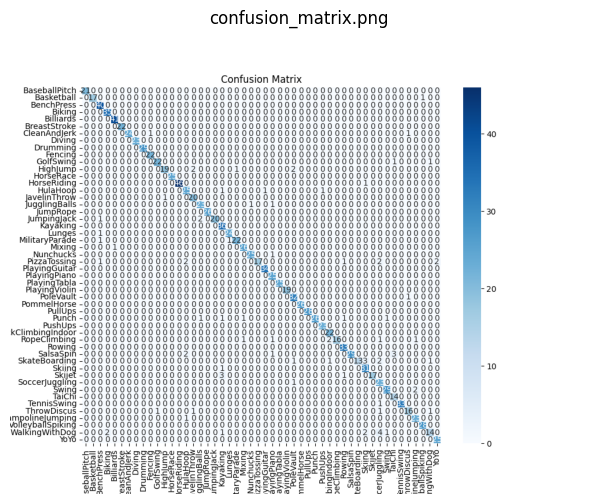

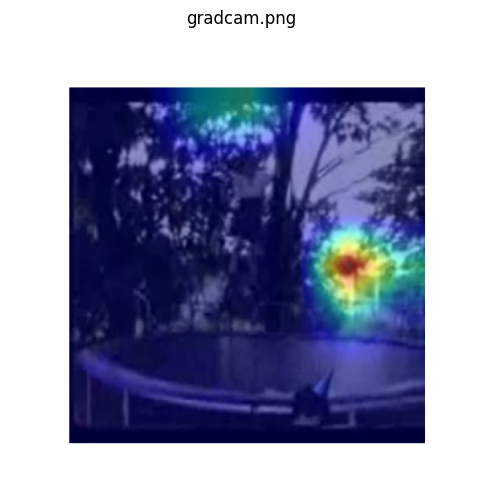

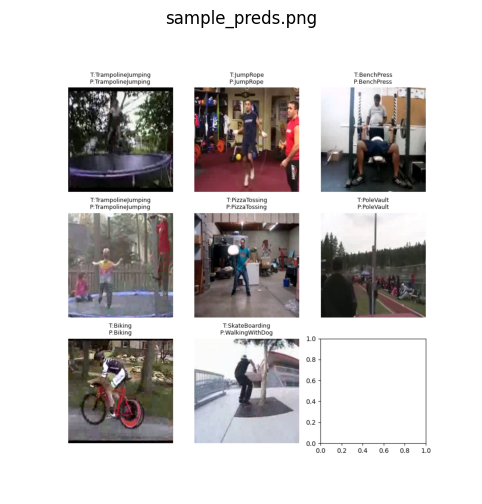

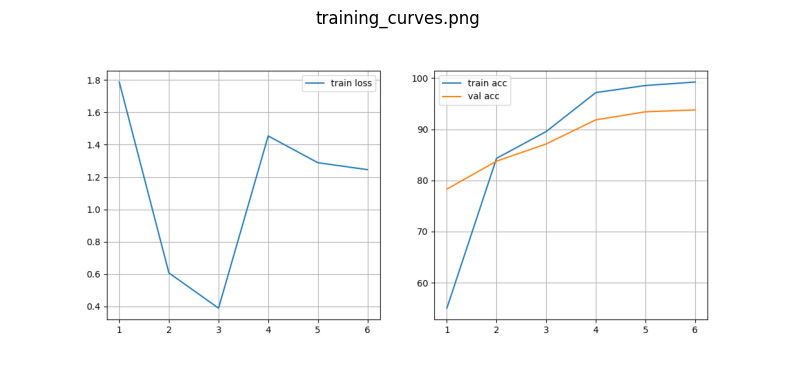

In [20]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Folder containing checkpoints
ckpt_dir = './checkpoints'

# List of PNG files to display
png_files = [
    'confusion_matrix.png',
    'gradcam.png',
    'sample_preds.png',
    'training_curves.png'
]

# Display images
for fname in png_files:
    path = os.path.join(ckpt_dir, fname)
    if os.path.exists(path):
        img = Image.open(path)
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(fname)
        plt.show()
    else:
        print(f"{fname} not found in {ckpt_dir}")


In [21]:
import shutil
import os

# Source folder
src_dir = './checkpoints'

# Destination folder (create if doesn't exist)
dst_dir = './model_files'
os.makedirs(dst_dir, exist_ok=True)

# List of files you want to move/copy
files_to_move = ['best.pth', 'final.pth', 'history.pth', 'val_indices.pth']

for fname in files_to_move:
    src_path = os.path.join(src_dir, fname)
    dst_path = os.path.join(dst_dir, fname)
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)  # use shutil.move() if you want to move
        print(f"Copied {fname} to {dst_dir}")
    else:
        print(f"{fname} not found in {src_dir}")

Copied best.pth to ./model_files
Copied final.pth to ./model_files
Copied history.pth to ./model_files
Copied val_indices.pth to ./model_files


## HMDB51

In [6]:
# ds_stt_afo_hmdb51_on_the_fly.py
# Training pipeline for HMDB51 (frame-folder) with on-the-fly teacher flow (no global precompute)
# Multi-GPU DataParallel kept as before.

import os
import shutil
import random
import numpy as np
from pathlib import Path
from tqdm import tqdm

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler

import torchvision.transforms as transforms
import torchvision.models as models
from einops import rearrange

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------
# USER: set this to your Kaggle path
# Example: hmdb51_path = "/kaggle/input/hmdb51_frames/HMDB51"
hmdb51_path = "/kaggle/input/hmdb51/HMDB51"   # <<---- replace this with your actual path
# ---------------------------------

# -----------------------------
# 1. SETUP & CONFIG
# -----------------------------
CONFIG = {
    'dataset_path': hmdb51_path,
    'save_dir': './checkpoints_hmdb',
    'teacher_flow_dir': './teacher_flows_hmdb',  # unused by default

    'num_frames': 16,
    'frames_to_select': 8,
    'img_size': 224,

    'num_classes': 51,

    'batch_size': 16,
    'accumulation_steps': 2,
    'lr': 1e-4,
    'weight_decay': 1e-2,
    'num_workers': 8,

    'epochs_mhn_pretrain': 3,
    'epochs_classifier': 3,
    'epochs_finetune': 3,

    # We are using on-the-fly flows by default; set True if you really want to precompute
    'precompute_teacher': False,
    'use_teacher_distill': True,

    'lambda_grad': 0.5,
    'beta_flow': 0.5,
    'alpha_sparsity': 0.01,

    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'seed': 42,
    'max_samples': None,
}

# -----------------------------
# UTILS & LOSSES
# -----------------------------
def set_seed(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

def flow_epe_loss(pred, target):
    return torch.norm(pred - target, dim=1).mean()

def flow_grad_loss(pred, target):
    def gradient(x):
        dx = x[:, :, :, 1:] - x[:, :, :, :-1]
        dy = x[:, :, 1:, :] - x[:, :, :-1, :]
        return dx, dy
    pdx, pdy = gradient(pred); tdx, tdy = gradient(target)
    return (pdx - tdx).abs().mean() + (pdy - tdy).abs().mean()

def entropy_sparsity_loss(masks):
    eps = 1e-8
    entropy = -torch.sum(masks * torch.log(masks + eps), dim=-1)
    return entropy.mean()

def gumbel_softmax_sample(logits, tau=1.0):
    u = torch.rand_like(logits)
    g = -torch.log(-torch.log(u + 1e-20) + 1e-20)
    return F.softmax((logits + g) / tau, dim=-1)

def get_module(model):
    return model.module if isinstance(model, nn.DataParallel) else model

# -----------------------------
# FRAME-FOLDER DATASET (Option A)
# -----------------------------
class FrameFolderDataset(Dataset):
    def __init__(self, root, num_frames, transform=None, max_samples=None):
        self.root = Path(root)
        self.num_frames = num_frames
        self.transform = transform
        self.samples = []
        if not self.root.exists():
            raise RuntimeError(f"Dataset root not found: {root}")
        classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {c:i for i,c in enumerate(classes)}
        for c in classes:
            class_dir = self.root / c
            for vid_dir in class_dir.iterdir():
                if vid_dir.is_dir():
                    self.samples.append((str(vid_dir), self.class_to_idx[c], vid_dir.name))
        if max_samples:
            self.samples = self.samples[:max_samples]
        self.cls_map = self.class_to_idx

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label, vid_id = self.samples[idx]
        video_path = Path(video_path)
        frame_paths = sorted([p for p in video_path.iterdir() if p.suffix.lower() in ('.jpg','.jpeg','.png')])
        if len(frame_paths) == 0:
            frames = [Image.new('RGB', (CONFIG['img_size'], CONFIG['img_size'])) for _ in range(self.num_frames)]
            frames = [self.transform(f) if self.transform else transforms.ToTensor()(f) for f in frames]
            return torch.stack(frames), label, vid_id

        indices = np.linspace(0, len(frame_paths)-1, self.num_frames).astype(int)
        frames = []
        for i in indices:
            img = Image.open(frame_paths[i]).convert('RGB')
            if self.transform:
                img = self.transform(img)
            else:
                img = transforms.ToTensor()(img)
            frames.append(img)
        return torch.stack(frames), label, vid_id

# -----------------------------
# MODEL DEFINITIONS
# -----------------------------
class MotionHallucinationNet(nn.Module):
    def __init__(self, in_ch=6, base_ch=32):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, base_ch, 3, 1, 1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True))
        self.pool = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(nn.Conv2d(base_ch, base_ch*2, 3, 1, 2, 2), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True))
        self.enc3 = nn.Sequential(nn.Conv2d(base_ch*2, base_ch*4, 3, 1, 4, 4), nn.BatchNorm2d(base_ch*4), nn.ReLU(inplace=True))
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = nn.Sequential(nn.Conv2d(base_ch*6, base_ch*2, 3, 1, 1), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True))
        self.dec1 = nn.Sequential(nn.Conv2d(base_ch*3, base_ch, 3, 1, 1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(base_ch, 2, 3, 1, 1)
    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool(e1)
        e2 = self.enc2(p1); p2 = self.pool(e2)
        e3 = self.enc3(p2)
        d2 = self.dec2(torch.cat([self.up(e3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1))
        return self.final(d1)

class DiffNet_Selector(nn.Module):
    def __init__(self, frames_to_select, use_gumbel=False):
        super().__init__()
        self.K = frames_to_select
        self.use_gumbel = use_gumbel
        mobilenet = models.mobilenet_v2(weights='DEFAULT')
        self.diff_encoder = nn.Sequential(*list(mobilenet.features.children())[:7])
        with torch.no_grad():
            dummy = torch.randn(1,3,CONFIG['img_size'],CONFIG['img_size'])
            feat_ch = self.diff_encoder(dummy).shape[1]
        self.saliency_head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(feat_ch, 1))
    def forward(self, frames, tau=1.0):
        B, T = frames.shape[:2]
        diffs = frames[:,1:] - frames[:,:-1]
        feats = self.diff_encoder(rearrange(diffs, 'b t c h w -> (b t) c h w'))
        logits = self.saliency_head(feats).view(B, T-1)
        logits = torch.cat([logits, torch.zeros(B,1, device=frames.device)], dim=1)
        if self.training:
            if self.use_gumbel:
                masks = torch.cat([gumbel_softmax_sample(logits, tau).unsqueeze(1) for _ in range(self.K)], dim=1)
            else:
                masks = F.softmax(logits, dim=1).unsqueeze(1).repeat(1, self.K, 1)
            return masks, logits
        else:
            _, indices = torch.topk(logits, self.K, dim=1)
            return torch.sort(indices, dim=1)[0], logits

class DS_STT_AFO(nn.Module):
    def __init__(self, num_classes, frames_to_select, use_gumbel=False):
        super().__init__()
        self.selector = DiffNet_Selector(frames_to_select, use_gumbel)
        self.mhn = MotionHallucinationNet()
        res_rgb = models.resnet34(weights='DEFAULT'); res_flow = models.resnet34(weights='DEFAULT')
        self.rgb_enc = nn.Sequential(*list(res_rgb.children())[:-2])
        self.flow_enc = nn.Sequential(*list(res_flow.children())[:-2])
        with torch.no_grad():
            w = self.flow_enc[0].weight.mean(1, keepdim=True).repeat(1,2,1,1)
            self.flow_enc[0] = nn.Conv2d(2,64,7,2,3,bias=False)
            self.flow_enc[0].weight.copy_(w)
        self.dim = 512
        self.rgb_proj = nn.Linear(512, self.dim); self.flow_proj = nn.Linear(512, self.dim)
        self.cross_attn = nn.MultiheadAttention(self.dim, 8, batch_first=True)
        self.flow_gate = nn.Parameter(torch.zeros(1))
        enc = nn.TransformerEncoderLayer(self.dim, 8, 2048, 0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(enc, 4)
        self.pos_embed = nn.Parameter(torch.randn(1, frames_to_select, self.dim) * 0.02)
        self.classifier = nn.Linear(self.dim, num_classes)
    def forward(self, x, tau=1.0, return_meta=False):
        B, T, C, H, W = x.shape
        sel_out, sel_logits = self.selector(x, tau)
        if self.training:
            rgb_k = torch.einsum('btchw,bkt->bkchw', x, sel_out)
            x_next = torch.cat([x[:,1:], x[:,-1:]], dim=1)
            rgb_k_next = torch.einsum('btchw,bkt->bkchw', x_next, sel_out)
        else:
            idx = sel_out
            batch = torch.arange(B, device=x.device).unsqueeze(1)
            rgb_k = x[batch, idx]
            rgb_k_next = x[batch, torch.clamp(idx+1, max=T-1)]
        pairs = rearrange(torch.cat([rgb_k, rgb_k_next], dim=2), 'b k c h w -> (b k) c h w')
        pred_flow = self.mhn(pairs)
        rgb_in = rearrange(rgb_k, 'b k c h w -> (b k) c h w')
        rgb_map = self.rgb_enc(rgb_in); rgb_pooled = F.adaptive_avg_pool2d(rgb_map, (1,1)).flatten(1)
        rgb_feat = self.rgb_proj(rgb_pooled).view(B, -1, self.dim)
        norm_flow = pred_flow / max(H, W)
        flow_map = self.flow_enc(norm_flow); flow_pooled = F.adaptive_avg_pool2d(flow_map, (1,1)).flatten(1)
        flow_feat = self.flow_proj(flow_pooled).view(B, -1, self.dim)
        attn_out = self.cross_attn(rgb_feat, flow_feat, flow_feat)[0]
        fused = rgb_feat + self.flow_gate * attn_out + self.pos_embed
        encoded = self.transformer(fused)
        logits = self.classifier(encoded.mean(1))
        if return_meta:
            return logits, {'pred_flow': pred_flow.view(B, -1, 2, H, W), 'sel_logits': sel_logits, 'sel_out': sel_out}
        return logits

# -----------------------------
# HELPER: denormalize tensor -> uint8 RGB numpy
# -----------------------------
def denorm_tensor_to_uint8(img_tensor):
    """
    img_tensor: C,H,W normalized (tensor or numpy)
    returns HxW x 3 uint8 RGB numpy
    """
    if isinstance(img_tensor, torch.Tensor):
        arr = img_tensor.cpu().numpy()
    else:
        arr = img_tensor
    # arr: C,H,W
    mean = np.array([0.485,0.456,0.406])[:,None,None]
    std = np.array([0.229,0.224,0.225])[:,None,None]
    img = arr * std + mean  # still in 0..1 (float)
    img = np.clip(img, 0, 1)
    img = (img * 255.).astype(np.uint8)
    img = np.transpose(img, (1,2,0))  # H,W,C
    return img

# -----------------------------
# ON-THE-FLY FLOW FUNCTIONS
# -----------------------------
def compute_flow_for_pairs_on_the_fly(frames_cpu, t, downscale=2):
    """
    Compute flow for pairs (t,t+1) for each sample in the batch.
    frames_cpu: Tensor (B, T, C, H, W) on CPU, normalized
    t: index
    returns Tensor (B, 2, H, W) on CPU (float32)
    """
    B, T, C, H, W = frames_cpu.shape
    save_h, save_w = H//downscale, W//downscale
    flows = []
    for b in range(B):
        im1 = denorm_tensor_to_uint8(frames_cpu[b, t])
        im2 = denorm_tensor_to_uint8(frames_cpu[b, t+1])
        im1_small = cv2.resize(im1, (save_w, save_h), interpolation=cv2.INTER_AREA)
        im2_small = cv2.resize(im2, (save_w, save_h), interpolation=cv2.INTER_AREA)
        g1 = cv2.cvtColor(im1_small, cv2.COLOR_RGB2GRAY)
        g2 = cv2.cvtColor(im2_small, cv2.COLOR_RGB2GRAY)
        flow = cv2.calcOpticalFlowFarneback(g1, g2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flow_t = torch.from_numpy(flow.astype(np.float32)).permute(2,0,1)  # 2, h, w
        flow_up = F.interpolate(flow_t.unsqueeze(0), size=(H,W), mode='bilinear', align_corners=False).squeeze(0)
        flows.append(flow_up)
    return torch.stack(flows, dim=0)  # B,2,H,W

def compute_teacher_flow_on_the_fly(frames_cpu, sel_masks, device, downscale=2):
    """
    frames_cpu: Tensor (B, T, C, H, W) on CPU, normalized
    sel_masks: Tensor (B, K, T) on device (soft selection masks)
    returns: Tensor (B, K, 2, H, W) on device
    """
    B, T, C, H, W = frames_cpu.shape
    save_h, save_w = H//downscale, W//downscale
    all_batch = []
    # compute flows for each sample b across all t pairs
    for b in range(B):
        flows = []
        for t in range(T-1):
            im1 = denorm_tensor_to_uint8(frames_cpu[b, t])
            im2 = denorm_tensor_to_uint8(frames_cpu[b, t+1])
            im1_small = cv2.resize(im1, (save_w, save_h), interpolation=cv2.INTER_AREA)
            im2_small = cv2.resize(im2, (save_w, save_h), interpolation=cv2.INTER_AREA)
            g1 = cv2.cvtColor(im1_small, cv2.COLOR_RGB2GRAY)
            g2 = cv2.cvtColor(im2_small, cv2.COLOR_RGB2GRAY)
            flow = cv2.calcOpticalFlowFarneback(g1, g2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            flow_t = torch.from_numpy(flow.astype(np.float32)).permute(2,0,1)  # 2, h, w
            flow_up = F.interpolate(flow_t.unsqueeze(0), size=(H,W), mode='bilinear', align_corners=False).squeeze(0)
            flows.append(flow_up)
        if len(flows) == 0:
            vid_stack = torch.zeros((1,2,H,W), dtype=torch.float32)
        else:
            vid_stack = torch.stack(flows)  # (T-1, 2, H, W)
        # get weights from sel_masks (on device) and move to CPU for combination, then back to device
        weights = sel_masks[b, :, :-1].cpu().float()  # K x (T-1)
        weights = weights / (weights.sum(dim=1, keepdim=True) + 1e-8)
        # vid_stack: (T-1, 2, H, W) -> want (K, 2, H, W)
        combined = torch.einsum('kt, tchw -> kchw', weights, vid_stack)  # K,2,H,W
        all_batch.append(combined)
    result = torch.stack(all_batch, dim=0).to(device)  # B,K,2,H,W
    return result

# -----------------------------
# (optional) old precompute kept for reference
# -----------------------------
def precompute_teacher_flows_from_frames(dataset_root, save_dir, num_frames, max_samples):
    ds = FrameFolderDataset(dataset_root, num_frames, transform=None, max_samples=max_samples)
    os.makedirs(save_dir, exist_ok=True)
    print("Precomputing teacher flows (Compressed 112x112, float16)...")
    save_h, save_w = CONFIG['img_size'] // 2, CONFIG['img_size'] // 2
    for i in tqdm(range(len(ds))):
        frames, _, vid_id = ds[i]
        frames_np = []
        for f in frames:
            img = (f.permute(1,2,0).numpy() * 255.).astype(np.uint8)
            bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            frames_np.append(cv2.resize(bgr, (CONFIG['img_size'], CONFIG['img_size']), interpolation=cv2.INTER_AREA))
        gray = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in frames_np]
        for t in range(len(gray)-1):
            p = os.path.join(save_dir, f"{vid_id}_{t}.npy")
            if os.path.exists(p): continue
            flow = cv2.calcOpticalFlowFarneback(gray[t], gray[t+1], None, 0.5, 3, 15, 3, 5, 1.2, 0)
            flow_small = cv2.resize(flow, (save_w, save_h), interpolation=cv2.INTER_AREA)
            np.save(p, flow_small.astype(np.float16))

# -----------------------------
# TRAINING & VALIDATION (uses on-the-fly teacher flows)
# -----------------------------
def train_one_epoch(model, loader, optimizer, scaler, criterion, device, stage):
    model.train(); total_loss = 0.0; correct = 0; total = 0
    for i, (frames, labels, vid_ids) in enumerate(tqdm(loader, desc=f"Train {stage}")):
        # keep CPU copy for on-the-fly flow computation
        frames_cpu = frames.clone()  # B, T, C, H, W on CPU
        frames, labels = frames.to(device), labels.to(device)
        with autocast():
            logits, meta = model(frames, return_meta=True)
            ce = criterion(logits, labels)
            sparsity = entropy_sparsity_loss(meta['sel_out'])
            flow_loss = torch.tensor(0., device=device)
            if stage == 'C' and CONFIG['use_teacher_distill']:
                # compute soft teacher flows on-the-fly for this batch
                teacher = compute_teacher_flow_on_the_fly(frames_cpu, meta['sel_out'], device, downscale=2)
                pred = meta['pred_flow']
                flow_loss = flow_epe_loss(pred, teacher) + CONFIG['lambda_grad'] * flow_grad_loss(pred, teacher)
            loss = (ce + CONFIG['alpha_sparsity'] * sparsity + CONFIG['beta_flow'] * flow_loss) / CONFIG['accumulation_steps']
        scaler.scale(loss).backward()
        if (i + 1) % CONFIG['accumulation_steps'] == 0:
            scaler.unscale_(optimizer); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
        total_loss += loss.item() * CONFIG['accumulation_steps']
        correct += (logits.argmax(1) == labels).sum().item(); total += labels.size(0)
    # handle remainder
    if (i + 1) % CONFIG['accumulation_steps'] != 0:
        scaler.unscale_(optimizer); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
    print(f"Train {stage} Loss: {total_loss/len(loader):.4f} Acc: {100.*correct/total:.2f}%")
    return total_loss/len(loader), 100.*correct/total

def validate(model, loader, device):
    model.eval(); preds_all = []; labels_all = []
    with torch.no_grad():
        for frames, labels, _ in tqdm(loader, desc="Valid"):
            frames, labels = frames.to(device), labels.to(device)
            logits = model(frames)
            preds_all.append(logits.argmax(1).cpu().numpy()); labels_all.append(labels.cpu().numpy())
    preds_all = np.concatenate(preds_all); labels_all = np.concatenate(labels_all)
    acc = (preds_all == labels_all).mean() * 100.
    print(f"[val] Acc: {acc:.2f}%")
    return acc, preds_all, labels_all

# -----------------------------
# VISUALIZATION (kept same)
# -----------------------------
def visualize_everything(history, model, val_ds, val_dl, classes, save_dir, device='cuda', num_gradcam=3, num_preds=5):
    os.makedirs(save_dir, exist_ok=True)
    model_module = get_module(model)

    # 1) Training / Validation curves
    epochs = len(history['train_loss'])
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), history['train_acc'], marker='o', label='Train Acc')
    plt.plot(range(1, epochs+1), history['val_acc'], marker='o', label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training vs Validation Accuracy')
    plt.legend(); plt.grid(True)
    plt.savefig(os.path.join(save_dir, "train_val_accuracy.png"))
    plt.close()

    # 2) Confusion matrix on validation set (if preds available via validate)
    try:
        va, preds, labels = validate(model, val_dl, device)
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix (Val Acc: {va:.2f}%)')
        plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
        plt.close()
    except Exception as e:
        print("Skipping confusion matrix (error):", e)

    # 3) Grad-CAM function — register hook on rgb_enc output
    def compute_gradcam_single(video_frames, model_module, device):
        f_idx = video_frames.shape[0] // 2
        frame = video_frames[f_idx].unsqueeze(0).to(device)  # (1, C, H, W)
        frame = frame.requires_grad_(True)
        feat = model_module.rgb_enc(frame)
        def save_grad(g): model_module._grad = g
        feat.register_hook(save_grad)
        out = model_module.rgb_proj(F.adaptive_avg_pool2d(feat, 1).flatten(1)).sum()
        model_module.zero_grad(); out.backward()
        grads = getattr(model_module, "_grad", None)
        if grads is None:
            return None
        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = F.relu((weights * feat).sum(1, keepdim=True))
        cam = F.interpolate(cam, size=(CONFIG['img_size'], CONFIG['img_size']), mode='bilinear', align_corners=False)
        cam = cam.squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return f_idx, cam

    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])

    for i in range(min(num_gradcam, len(val_ds))):
        frames, label, vid_id = val_ds[i]
        try:
            f_idx, cam = compute_gradcam_single(frames, model_module, device)
            img = frames[f_idx].permute(1,2,0).cpu().numpy()
            img = (img * std + mean).clip(0,1)
            img = (img * 255).astype(np.uint8)
            heatmap = cv2.applyColorMap((cam*255).astype(np.uint8), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            overlay = (0.5 * img + 0.5 * heatmap).astype(np.uint8)
            plt.figure(figsize=(6,6))
            plt.title(f"Grad-CAM: vid {vid_id} (true: {classes[label]})")
            plt.imshow(overlay); plt.axis('off')
            plt.savefig(os.path.join(save_dir, f"gradcam_{vid_id}.png"))
            plt.close()
        except Exception as e:
            print("Grad-CAM failed for", vid_id, e)
            continue

    from torchvision.utils import make_grid
    for i in range(min(num_preds, len(val_ds))):
        frames, label, vid_id = val_ds[i]
        with torch.no_grad():
            inp = frames.unsqueeze(0).to(device)
            logits = model(inp)
            pred = int(logits.argmax(1).item())
        grid = make_grid(frames, nrow=min(8, frames.shape[0]))
        grid = grid.permute(1,2,0).cpu().numpy()
        grid = (grid * std + mean).clip(0,1)
        plt.figure(figsize=(12,3))
        plt.title(f"Video: {vid_id} | True: {classes[label]} | Pred: {classes[pred]}")
        plt.imshow(grid); plt.axis('off')
        plt.savefig(os.path.join(save_dir, f"pred_{vid_id}.png"))
        plt.close()

    print("Visualizations saved to", save_dir)

# -----------------------------
# MAIN TRAINING RUN
# -----------------------------
def run_training():
    set_seed(CONFIG['seed'])
    os.makedirs(CONFIG['save_dir'], exist_ok=True)
    device = CONFIG['device']

    # Transforms
    tfm = transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

    # Dataset
    ds = FrameFolderDataset(CONFIG['dataset_path'], CONFIG['num_frames'], tfm, CONFIG['max_samples'])
    train_sz = int(0.8 * len(ds))
    train_ds, val_ds = random_split(ds, [train_sz, len(ds)-train_sz])

    train_dl = DataLoader(train_ds, CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'],
                          pin_memory=True, persistent_workers=True if CONFIG['num_workers']>0 else False)
    val_dl = DataLoader(val_ds, CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'],
                        pin_memory=True, persistent_workers=True if CONFIG['num_workers']>0 else False)

    # Build model and move to device
    model = DS_STT_AFO(len(ds.cls_map), CONFIG['frames_to_select']).to(device)

    # Wrap in DataParallel if multiple GPUs available
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        print("Using DataParallel with {} GPUs".format(torch.cuda.device_count()))

    scaler = GradScaler(); criterion = nn.CrossEntropyLoss()
    history = {'train_loss':[], 'train_acc':[], 'val_acc':[]}
    best_val = -1.0

    # (No precompute by default)
    if CONFIG['precompute_teacher']:
        if os.path.exists(CONFIG['teacher_flow_dir']):
            shutil.rmtree(CONFIG['teacher_flow_dir'])
        precompute_teacher_flows_from_frames(CONFIG['dataset_path'], CONFIG['teacher_flow_dir'], CONFIG['num_frames'], CONFIG['max_samples'])

    # STAGE A: MHN pretrain (on-the-fly pair flows)
    print("=== Stage A: MHN pretrain ===")
    opt_mhn = optim.AdamW(get_module(model).mhn.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    for ep in range(CONFIG['epochs_mhn_pretrain']):
        get_module(model).mhn.train()
        total = 0.0
        for frames, _, vid_ids in tqdm(train_dl, desc=f"MHN Pretrain Epoch {ep+1}/{CONFIG['epochs_mhn_pretrain']}"):
            # keep CPU copy
            frames_cpu = frames.clone()
            frames = frames.to(device)
            t = random.randint(0, CONFIG['num_frames']-2)
            pair = torch.cat([frames[:,t], frames[:,t+1]], dim=1)  # (B, 6, H, W)
            with autocast():
                pred = get_module(model).mhn(pair)
                if CONFIG['use_teacher_distill']:
                    targets = compute_flow_for_pairs_on_the_fly(frames_cpu, t, downscale=2).to(device)  # B,2,H,W
                    loss = flow_epe_loss(pred, targets)
                else:
                    loss = torch.tensor(0., device=device, requires_grad=True)
            scaler.scale(loss).backward()
            scaler.step(opt_mhn); scaler.update(); opt_mhn.zero_grad()
            total += loss.item()
        print(f"MHN Epoch {ep+1} Loss: {total/len(train_dl):.4f}")

    # STAGE B: Train classifier with MHN frozen
    print("=== Stage B: Train classifier ===")
    for p in get_module(model).mhn.parameters():
        p.requires_grad = False
    opt = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    for ep in range(CONFIG['epochs_classifier']):
        tloss, tacc = train_one_epoch(model, train_dl, opt, scaler, criterion, device, 'B')
        va, _, _ = validate(model, val_dl, device)
        history['train_loss'].append(tloss); history['train_acc'].append(tacc); history['val_acc'].append(va)
        if va > best_val:
            best_val = va
            torch.save(get_module(model).state_dict(), os.path.join(CONFIG['save_dir'], "best.pth"))
        print(f"Epoch {ep+1} | Train Loss: {tloss:.4f} | Train Acc: {tacc:.2f}% | Val Acc: {va:.2f}%")

    # STAGE C: Finetune MHN and whole model (uses on-the-fly soft teacher)
    print("=== Stage C: Finetune whole model ===")
    for p in get_module(model).mhn.parameters():
        p.requires_grad = True
    opt = optim.AdamW(model.parameters(), lr=CONFIG['lr']*0.1, weight_decay=CONFIG['weight_decay'])
    for ep in range(CONFIG['epochs_finetune']):
        tloss, tacc = train_one_epoch(model, train_dl, opt, scaler, criterion, device, 'C')
        va, _, _ = validate(model, val_dl, device)
        history['train_loss'].append(tloss); history['train_acc'].append(tacc); history['val_acc'].append(va)
        if va > best_val:
            best_val = va
            torch.save(get_module(model).state_dict(), os.path.join(CONFIG['save_dir'], "best.pth"))
        print(f"Epoch {ep+1} | Train Loss: {tloss:.4f} | Train Acc: {tacc:.2f}% | Val Acc: {va:.2f}%")

    print(f"Best Val: {best_val:.2f}%")

    # Load best model and visualize
    best_path = os.path.join(CONFIG['save_dir'], "best.pth")
    if os.path.exists(best_path):
        state = torch.load(best_path, map_location=device)
        get_module(model).load_state_dict(state)
    else:
        print("Best checkpoint not found, skipping load.")

    # Prepare classes map
    classes = [None] * len(ds.cls_map)
    for k,v in ds.cls_map.items():
        classes[v] = k

    visualize_everything(history, model, val_ds, val_dl, classes, CONFIG['save_dir'], device=device)

if __name__ == "__main__":
    run_training()

/tmp/ipykernel_47/4187842868.py:519: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(); criterion = nn.CrossEntropyLoss()


Using DataParallel with 2 GPUs
=== Stage A: MHN pretrain ===


MHN Pretrain Epoch 1/3:   0%|          | 0/339 [00:00<?, ?it/s]/tmp/ipykernel_47/4187842868.py:541: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
MHN Pretrain Epoch 1/3: 100%|██████████| 339/339 [03:16<00:00,  1.72it/s]


MHN Epoch 1 Loss: 1.5609


MHN Pretrain Epoch 2/3: 100%|██████████| 339/339 [03:02<00:00,  1.86it/s]


MHN Epoch 2 Loss: 1.3986


MHN Pretrain Epoch 3/3: 100%|██████████| 339/339 [03:01<00:00,  1.87it/s]


MHN Epoch 3 Loss: 1.3057
=== Stage B: Train classifier ===


Train B:   0%|          | 0/339 [00:00<?, ?it/s]/tmp/ipykernel_47/4187842868.py:361: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Train B: 100%|██████████| 339/339 [06:02<00:00,  1.07s/it]


Train B Loss: 2.8394 Acc: 26.57%


Valid: 100%|██████████| 85/85 [00:53<00:00,  1.58it/s]


[val] Acc: 34.05%
Epoch 1 | Train Loss: 2.8394 | Train Acc: 26.57% | Val Acc: 34.05%


Train B: 100%|██████████| 339/339 [05:59<00:00,  1.06s/it]


Train B Loss: 1.7333 Acc: 52.81%


Valid: 100%|██████████| 85/85 [00:51<00:00,  1.64it/s]


[val] Acc: 43.50%
Epoch 2 | Train Loss: 1.7333 | Train Acc: 52.81% | Val Acc: 43.50%


Train B: 100%|██████████| 339/339 [06:00<00:00,  1.06s/it]


Train B Loss: 1.2073 Acc: 66.69%


Valid: 100%|██████████| 85/85 [00:51<00:00,  1.65it/s]


[val] Acc: 41.43%
Epoch 3 | Train Loss: 1.2073 | Train Acc: 66.69% | Val Acc: 41.43%
=== Stage C: Finetune whole model ===


Train C: 100%|██████████| 339/339 [17:56<00:00,  3.18s/it]


Train C Loss: 1.5143 Acc: 83.48%


Valid: 100%|██████████| 85/85 [00:52<00:00,  1.63it/s]


[val] Acc: 50.89%
Epoch 1 | Train Loss: 1.5143 | Train Acc: 83.48% | Val Acc: 50.89%


Train C: 100%|██████████| 339/339 [17:42<00:00,  3.14s/it]


Train C Loss: 1.1564 Acc: 85.13%


Valid: 100%|██████████| 85/85 [00:52<00:00,  1.63it/s]


[val] Acc: 51.92%
Epoch 2 | Train Loss: 1.1564 | Train Acc: 85.13% | Val Acc: 51.92%


Train C: 100%|██████████| 339/339 [17:42<00:00,  3.13s/it]


Train C Loss: 1.0235 Acc: 87.95%


Valid: 100%|██████████| 85/85 [00:51<00:00,  1.64it/s]


[val] Acc: 53.55%
Epoch 3 | Train Loss: 1.0235 | Train Acc: 87.95% | Val Acc: 53.55%
Best Val: 53.55%


Valid: 100%|██████████| 85/85 [00:51<00:00,  1.64it/s]


[val] Acc: 53.55%
Visualizations saved to ./checkpoints_hmdb
